In [1]:
import os
import sys
import argparse
import numpy as np
import numba as nb
import scipy.stats
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from tools import merge_matrix, hic_norm, clean_matrix

In [2]:
hr_path = '/data1/lmh_data/MMSR_complete/analyse/HFFc6/hr/chr19_vc_1kb.npz'
complete_path = '/data1/lmh_data/MMSR_complete/analyse/HFFc6/replaced/chr19_vc_1kb.npz'
complete_enhanced_path = '/data1/lmh_data/MMSR_complete/analyse/HFFc6/chr19_enhanced.npz'

In [3]:
hr = np.load(hr_path)['hic'].astype(float)
complete = np.load(complete_path)['hic'].astype(float)
complete_enhanced = np.load(complete_enhanced_path)['out'].astype(float)

In [4]:
print(hr.shape)
print(complete.shape)
print(complete_enhanced.shape)

(147, 5, 400, 400)
(147, 5, 400, 400)
(147, 5, 400, 400)


In [5]:
for i in range(complete_enhanced.shape[0]):
    complete_enhanced[i][0] = (complete_enhanced[i][0] + complete_enhanced[i][0].T)/2

matrixs = [hr, complete, complete_enhanced]
for i in range(0, len(matrixs)):
    matrixs[i] = merge_matrix(matrixs[i])
    matrixs[i] = np.triu(matrixs[i]).T + np.triu(matrixs[i])

matrixs[0] = hic_norm(matrixs[0])
matrixs[1] = hic_norm(matrixs[1])

matrixs, Min = clean_matrix(matrixs)

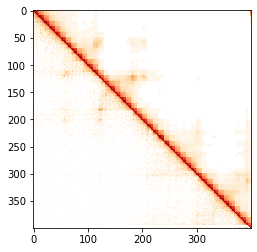

In [6]:
_min, _max = 800, 1200

complete_19=np.triu(matrixs[1][_min:_max, _min:_max]) # 上三角
hr_19=np.tril(matrixs[0][_min:_max, _min:_max]) # 下三角

complete_19 = complete_19 / complete_19.max()
hr_19 = hr_19 / hr_19.max()

complete_19[complete_19==0] = None
hr_19[hr_19==0] = None

pwargs = {'interpolation':'nearest'}
plt.imshow(complete_19, cmap=plt.cm.get_cmap('OrRd'), **pwargs)
plt.imshow(hr_19, cmap=plt.cm.get_cmap('OrRd'), **pwargs)
plt.savefig('fig/fig8_complete+hr.tif')
plt.show()

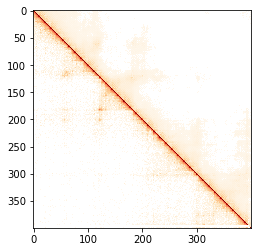

In [7]:
_min, _max = 800, 1200

enhanced_19=np.triu(matrixs[2][_min:_max, _min:_max]) # 上三角
hr_19=np.tril(matrixs[0][_min:_max, _min:_max]) # 下三角

enhanced_19 = enhanced_19 / enhanced_19.max()
hr_19 = hr_19 / hr_19.max()

enhanced_19[enhanced_19==0] = None
hr_19[hr_19==0] = None

pwargs = {'interpolation':'nearest'}
plt.imshow(enhanced_19, cmap=plt.cm.get_cmap('OrRd'), **pwargs)
plt.imshow(hr_19, cmap=plt.cm.get_cmap('OrRd'), **pwargs)
plt.savefig('fig/fig8_result+hr.tif')
plt.show()

In [8]:
@nb.jit()
def down_sample(matrix, ratio):
    dim = matrix.shape
    _l = int(dim[0]/ratio)
    _m = np.zeros((_l, _l))
    for i in range(_l):
        for j in range(_l):
            _m[i, j] = matrix[i*ratio:(i+1)*ratio, j*ratio:(j+1)*ratio].mean()
    return _m

dowm_hr = down_sample(matrixs[0], 10)
dowm_complete = down_sample(matrixs[1], 10)
down_result = down_sample(matrixs[2], 10)

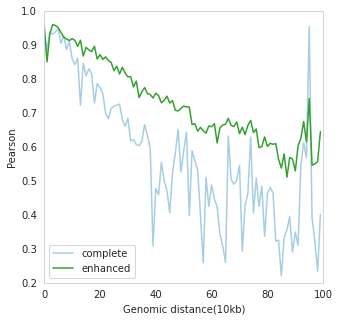

complete_y: 0.5771856932639036
enhanced: 0.7327224908516685


In [9]:
# 10kb PCC
chrom = 19
distance_all = [[0, chrom]]
dic_norm = {}
length = 100 # 1mb
for i in range(length):
    dic_norm[i]=[[], [], []]
for i in range(len(distance_all)):
    for j in range(-length+1, length, 1):
        dis = distance_all[i][0] - j
        dic_norm[abs(dis)][0]+=dowm_hr.diagonal(offset=j).tolist()
        dic_norm[abs(dis)][1]+=dowm_complete.diagonal(offset=j).tolist()
        dic_norm[abs(dis)][2]+=down_result.diagonal(offset=j).tolist()

complete_y, result_y = [], []
for i in range(length):
    complete_y.append(scipy.stats.pearsonr(dic_norm[i][0], dic_norm[i][1])[0])
    result_y.append(scipy.stats.pearsonr(dic_norm[i][0], dic_norm[i][2])[0])

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
axes.grid(False)
axes.plot(list(range(100)), complete_y, color=(166/255, 206/255, 227/255), label='complete')
axes.plot(list(range(100)), result_y, color=(51/255, 160/255, 44/255), label='enhanced')

plt.ylim(0.2, 1)
plt.xlabel('Genomic distance(10kb)')
plt.ylabel('Pearson')
plt.xlim(0, 100)
plt.legend()
plt.savefig('fig/fig8_10kb_PCC.pdf')
plt.show()

print("complete_y: {}".format(np.mean(complete_y)))
print("enhanced: {}".format(np.mean(result_y)))

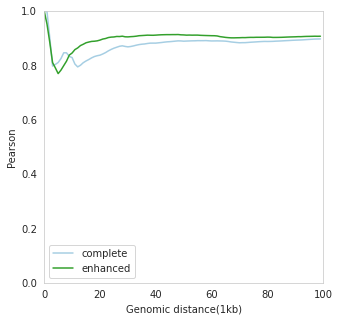

complete_y: 0.87524457117242
enhanced: 0.8971382465265182


In [10]:
# 1kb PCC
@nb.jit(nopython=True)
def make_PCCscore(matrix1, matrix2, begin, radius):
    scores = []
    for i in range(0, radius):
        _s = np.corrcoef(matrix1[begin-i:begin+i, begin-i:begin+i].flatten(), matrix2[begin-i:begin+i, begin-i:begin+i].flatten())[0, 1]
        if np.isnan(_s):
            _s = 1
        scores.append(_s)
    return scores

begin, radius = 920, 100
complete_y = make_PCCscore(matrixs[0], matrixs[1], begin, radius)
result_y = make_PCCscore(matrixs[0], matrixs[2], begin, radius)

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
axes.grid(False)
axes.plot(list(range(radius)), complete_y, color=(166/255, 206/255, 227/255), label='complete')
axes.plot(list(range(radius)), result_y, color=(51/255, 160/255, 44/255), label='enhanced')

plt.ylim(0, 1)
plt.xlabel('Genomic distance(1kb)')
plt.ylabel('Pearson')
plt.xlim(0, radius)
plt.legend()
plt.savefig('fig/fig8_1kb_PCC.pdf')
plt.show()

print("complete_y: {}".format(np.mean(complete_y)))
print("enhanced: {}".format(np.mean(result_y)))

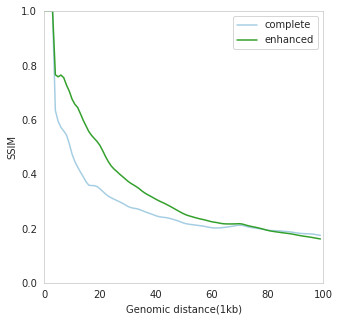

complete_y: 0.2942212647414851
enhanced: 0.3520063027259647


In [11]:
# 1kb ssim
# @nb.jit(nopython=True)
def make_SSIMscore(matrix1, matrix2, begin, radius):
    scores = [1]*4
    for i in range(4, radius):
        _s = structural_similarity(matrix1[begin-i:begin+i, begin-i:begin+i], matrix2[begin-i:begin+i, begin-i:begin+i])
        if np.isnan(_s):
            _s = 1
        scores.append(_s)
    return scores

begin, radius = 920, 100
complete_y = make_SSIMscore(matrixs[0], matrixs[1], begin, radius)
result_y = make_SSIMscore(matrixs[0], matrixs[2], begin, radius)

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
axes.grid(False)
axes.plot(list(range(radius)), complete_y, color=(166/255, 206/255, 227/255), label='complete')
axes.plot(list(range(radius)), result_y, color=(51/255, 160/255, 44/255), label='enhanced')

plt.ylim(0, 1)
plt.xlabel('Genomic distance(1kb)')
plt.ylabel('SSIM')
plt.xlim(0, radius)
plt.legend()
plt.savefig('fig/fig8_1kb_SSIM.pdf')
plt.show()

print("complete_y: {}".format(np.mean(complete_y)))
print("enhanced: {}".format(np.mean(result_y)))

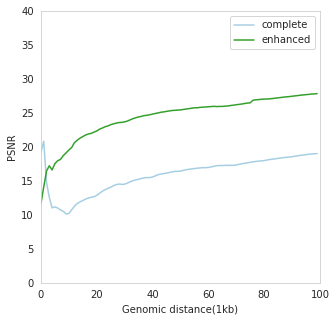

complete_y: 15.88147999546459
enhanced: 24.361304921722798


In [12]:
# 1kb psnr
# @nb.jit(nopython=True)
def make_PSNRscore(matrix1, matrix2, begin, radius):
    scores = []
    for i in range(0, radius):
        _m1 = matrix1[begin-i:begin+i+1, begin-i:begin+i+1]
        _m2 = matrix2[begin-i:begin+i+1, begin-i:begin+i+1]
        _range = max(_m1.max(), _m2.max())
        _s = peak_signal_noise_ratio(_m1, _m2, data_range=_range)
        if np.isnan(_s):
            _s = 1
        scores.append(_s)
    return scores

begin, radius = 920, 100
complete_y = make_PSNRscore(matrixs[0], matrixs[1], begin, radius)
result_y = make_PSNRscore(matrixs[0], matrixs[2], begin, radius)

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
axes.grid(False)
axes.plot(list(range(radius)), complete_y, color=(166/255, 206/255, 227/255), label='complete')
axes.plot(list(range(radius)), result_y, color=(51/255, 160/255, 44/255), label='enhanced')

plt.ylim(0, 40)
plt.xlabel('Genomic distance(1kb)')
plt.ylabel('PSNR')
plt.xlim(0, radius)
plt.legend()
plt.savefig('fig/fig8_1kb_PSNR.pdf')
plt.show()

print("complete_y: {}".format(np.mean(complete_y)))
print("enhanced: {}".format(np.mean(result_y)))

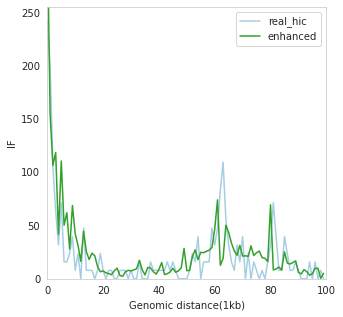

In [13]:
begin, radius = 920, 100
hr_y = matrixs[0][begin, begin:begin+radius]
result_y = matrixs[2][begin, begin:begin+radius]

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
axes.grid(False)
axes.plot(list(range(radius)), hr_y, color=(166/255, 206/255, 227/255), label='real_hic')
axes.plot(list(range(radius)), result_y, color=(51/255, 160/255, 44/255), label='enhanced')

plt.ylim(0, 255)
plt.xlabel('Genomic distance(1kb)')
plt.ylabel('IF')
plt.xlim(0, radius)
plt.legend()
plt.savefig('fig/fig8_1kb_IF.pdf')
plt.show()